## 5 Pretraining on unlabeled data

### 5.1 Evaluating generative text models

#### 5.1.1 Using GPT to generate text

In [1]:
import torch
import previous_chapters
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" # for openAI's pretrained weights
        ]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.7
numpy version: 2.3.4
tiktoken version: 0.12.0
torch version: 2.9.0
tensorflow version: 2.20.0


In [2]:
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, # Context size reduced for better performance
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [3]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

model.eval(); # inference/pred mode to suppress randomness
# SEMICOLON SUPPRESSES OUTPUT (otherwise the model architechture is printed)

device = "cuda" if torch.cuda.is_available else "cpu"

In [4]:
import tiktoken
from previous_chapters import generate_text_simple

# Convert text to token ids
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add a dimension for batching
    return encoded_tensor

In [5]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = text_to_token_ids(start_context, tokenizer)

In [6]:
from torch import Tensor
from tiktoken import Encoding

def token_ids_to_text(token_ids: Tensor, tokenizer: Encoding):
    flat = token_ids.squeeze(0) # remove batching dimension
    return tokenizer.decode(flat.tolist())
    # tiktoken works with python lists, so the argument for the decode function needs to be a list as well.

In [7]:
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you'

In [8]:
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

In [9]:
token_ids

tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])

In [10]:
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you rentingetic wasnم refres RexMeCHicular stren'

Again, nonsense output because no training was done. Without training, we cannot determine how accurate generated text is.

### 5.1.2 Calculating the text generation loss: cross-entropy and perplexity

In [11]:
inputs = torch.tensor([[16833, 3626, 6100],
                        [40, 1107, 588]])

# ["every effort moves", <- first input
#  "I really like"] <- second input
# this is a batch of two inputs

targets = torch.tensor([[3626, 6100, 345],
                        [1107, 588, 11311]])

# ["effort moves you", <- first target output
#  "really like chocolate"] <- second target output

In [12]:
with torch.no_grad():
    logits = model(inputs)

In [13]:
logits.shape

torch.Size([2, 3, 50257])

2 rows, each row has 3 tokens, and each of the logits is a 50257 length vector corresponding to likelihoods of each vocab word

In [14]:
preds = torch.softmax(logits, dim=-1)
preds.shape

torch.Size([2, 3, 50257])

In [15]:
preds

tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0538e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
          5.8203e-05, 1.3698e-05]]])

In [16]:
token_ids = torch.argmax(preds, dim=-1, keepdim=False)
token_ids

tensor([[16657,   339, 42826],
        [49906, 29669, 41751]])

In [17]:
print(f"Targets Batch 1: {token_ids_to_text(targets[0:1, :], tokenizer)}")

print(f"Preds Batch 1:   {token_ids_to_text(token_ids[0:1, :], tokenizer)}")

Targets Batch 1:  effort moves you
Preds Batch 1:    Armed heNetflix


In [18]:
target_probas1 = preds[0, [0, 1, 2], targets[0]]
print("Text 1: ", target_probas1)

Text 1:  tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])


In [19]:
target_probas2 = preds[1, [0, 1, 2], targets[1]]
print("Text 2: ", target_probas2)

Text 2:  tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [20]:
torch.log(torch.cat((target_probas1, target_probas2)))

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])

In [21]:
log_probas = torch.log(torch.cat((target_probas1, target_probas2)))
print("Log probabilities: ", log_probas)

Log probabilities:  tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [22]:
-1*torch.mean(log_probas)

tensor(10.7940)

Above is the cross entropy loss. We want to get this as close to zero as possible.

In [23]:
logits_flat = logits.flatten(0, 1)
logits_flat.shape

torch.Size([6, 50257])

This basically does the torch cat that we did earlier

In [24]:
targets_flat = targets.flatten()
targets_flat.shape

torch.Size([6])

In [25]:
torch.nn.functional.cross_entropy(logits_flat, targets_flat)

tensor(10.7940)

### 5.1.3 Calculating the training and validation set losses

In [26]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode("utf-8")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)

else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [27]:
text_data[:99]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

In [28]:
total_chars = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters: ", total_chars)
print("Tokens: ", total_tokens)

Characters:  20479
Tokens:  5145


Need to make a train-test split to actually train the GPT model

In [29]:
# the first 6 tokens become the first training sample,
# the next 6 tokens become the second training sample, and so on.

# then we group samples into batches for training (batch size 2 here)

from previous_chapters import create_dataloader_v1

train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [30]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True, # drop last incomplete batch
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [31]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [32]:
print("Validation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [33]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel() # numel -> num elements

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [34]:
def calc_loss_batch(input_batch : Tensor, target_batch : Tensor, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else: 
        # reduce num batches to match the total num of batches in the data loader if num batches exceeds that in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):    
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
torch.manual_seed(123)

with torch.no_grad(): # disable gradient tracking for efficiency because we are not training yet
    model.to("cuda") # to prevent tensor misalignment
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# Perplexity
torch.exp(torch.tensor(10.9875))

tensor(59130.3828)

the perplexity kind of tells us how many words the model is unsure about in the vocabulary. Here, it is greater than the actual vocab size, indicating that the model is basically completely untrained (which it is)

## 5.2 Training an LLM

In [ ]:
from torch.utils.data import DataLoader

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # main training loop
    for epoch in range(num_epochs):
        model.train() # set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device) # cross-entropy loss
            loss.backward() # calc loss gradients
            optimizer.step() # update model weights using loss gradients (SGD, Adam, etc)
            tokens_seen += input_batch.numel()
            global_step += 1

            # optional eval step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
            # Print sample text after each epoch
            generate_and_print_sample(
                model, tokenizer, device, start_context
            )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) #using adam here (could use SGD)

In [ ]:
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.819, Val loss 9.926
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the the,,,,,,,,,,,,,,,,,,,
Every effort moves you,.                                                
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Every effort moves you, the,, the the the the the,,,,, the,,,, the,,,,, the the,, the,, the the the,, the the the, the the the the,,,,,
Ep 1 (Step 000005): Train loss 8.068, Val loss 8.340
Every effort moves you, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Every effort moves you, the, the the the the the the the the the the the the the the the the the the the the the                          
Every effort moves you,,,,,,,,,,,,.                                     
Every effort moves you,,,,,,

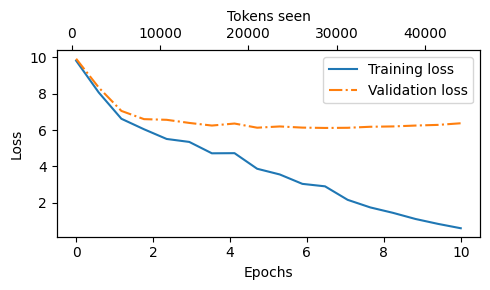

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle = "-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # create a second x-axis for tokens seen
    ax2 = ax1.twiny() # Create a second x axis that shares the same y axis
    ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout() # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The model actually began overfitting quite quickly and wasn't able to predict well on unseen data

### 5.3 Decoding strategies to control randomness

We usually want some randomness in the text; as things stand, the generated text actually contains direct excerpts from the original training text verbatim as a result of overfitting and picking the ARGMAX token to generate. 

This results in a deterministic generation output, which is a bit uninspired when it comes to inference problems; we want a generative language model to be a little creative and nuanced!

In [ ]:
model.to("cuda")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to("cuda"), # making sure all tensors are on cuda. 
    max_new_tokens = 25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the fact with equanimity. Gisburn's an awful simpleton


### 5.3.1 Temperature Scaling

In [ ]:
# Tiny vocab for illustrative purposes

vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8
}

inverse_vocab = {v: k for k, v in vocab.items()}
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [ ]:
# would normally generate these by passing input to a model, but let's pretend we just have them as is. 
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
).to(device)

probas = torch.softmax(next_token_logits, dim=0)
probas

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03], device='cuda:0')

In [ ]:
next_token_id = torch.argmax(probas).item()
next_token_id

3

In [ ]:
inverse_vocab[int(next_token_id)] # had to wrap in int so as to suppress type mismatch error. 

'forward'

The above method (using argmax) is *deterministic*. In other words, the model will always output the exact same token. Below is a sampling based method that has a chance of generating less likely tokens through weighted sampling.

In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[int(next_token_id)])

toward


The generated token changed.

We can also repeat this process many times (should see the proba distribution replicated)

In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

52 x closer
1 x every
0 x effort
603 x forward
2 x inches
0 x moves
0 x pizza
336 x toward
6 x you


In [ ]:
def softmax_with_temperature(logits : Tensor, temperature, device):
    logits.to(device) # making sure tensors are on the same device
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

In [ ]:
temperatures = [1, 0.1, 5]
# temperatures are applied before the softmax procedure. Low temperatures (close to 0) will sharpen the peaks (less random choices). High temperatures will smooth out the distribution (more random choices)

scaled_probas = [softmax_with_temperature(next_token_logits, T, device) for T in temperatures]
scaled_probas

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
         1.0120e-04, 3.5758e-01, 4.0122e-03], device='cuda:0'),
 tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
         2.9718e-38, 9.0133e-03, 2.8514e-22], device='cuda:0'),
 tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898],
        device='cuda:0')]

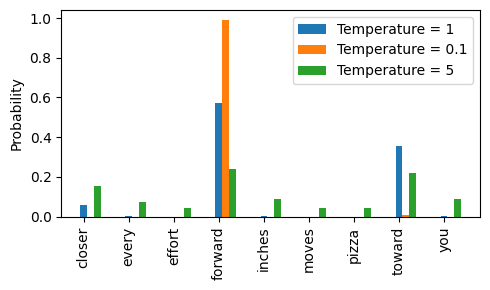

In [ ]:
# plotting the distributions 

x = torch.arange(len(vocab)) # matplotlib (and by extension numpy) ONLY WORK WITH CPU MEMORY, and as such, cannot parse tensors that live on the GPU. This means that for plotting purposes, these tensors must be migrated to the CPU (or initialized there to begin with)
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i].cpu(), bar_width, label=f'Temperature = {T}')

    # put scaled_probas[i] onto the CPU otherwise error

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

### 5.3.2 Top-k sampling

Top k sampling selects the top k highest logits in our output tensor, and mask any other logits by setting them to -inf. When softmax is applied, probabilities are generated such that only the top-k logits are possible (because all other logits go to 0 probability)

In [ ]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
).to(device)
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print(top_logits, top_pos)

tensor([6.7500, 6.2800, 4.5100], device='cuda:0') tensor([3, 7, 0], device='cuda:0')


In [ ]:
new_logits = torch.where(
    condition= next_token_logits < top_logits[-1], # wherever a logit is lower than the last logit in the top k list, mask.
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)

new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf],
       device='cuda:0')

In [ ]:
torch.softmax(new_logits, dim=0)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000],
       device='cuda:0')

### 5.3.3 Modifying the text generation function

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k)
            new_logits = torch.where(
                condition= logits < top_logits[:, -1], # wherever a logit is lower than the last logit in the top k list, mask.
                input = torch.tensor(float("-inf")),
                other = logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        
        else:
            # greedy sampling
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  

        # If we can teach an LLM to use the EOS (end of sequence) token, it can generate shorter answers if they are more optimal, saving time and money
        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)  

    return idx


In [ ]:
# default (same output as before)

torch.manual_seed(123)

token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    # top_k=25,
    # temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the fact with equanimity. Gisburn's an awful simpleton


In [ ]:
# new and improved

torch.manual_seed(123)

token_ids = generate(
    model = model,
    idx = text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=5,
    temperature=1.005
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as studio were, his pictures tooenez. " Granted_> with equanimity. Victor Grindle was; lou flashfor


## 5.4 Loading and saving model weights in PyTorch

In [ ]:
torch.save(model.state_dict(), "model.pth")

check [testing_load_small_model.ipynb](testing_load_small_model.ipynb) to see loading the small model in action

## 5.5 Loading pretrained weights from OpenAI

In [ ]:
print("Tensorflow version:", version("tensorflow"))
print("tqdm version", version("tqdm"))

Tensorflow version: 2.20.0
tqdm version 4.67.1


trying to just grab sebastians method directly from the file to see if it works

In [ ]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch


import os

import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    backup_base_url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        backup_url = os.path.join(backup_base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path, backup_url)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8"))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        response = requests.get(download_url, stream=True, timeout=60)
        response.raise_for_status()

        file_size = int(response.headers.get("Content-Length", 0))

        # Check if file exists and has same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size and file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return True

        block_size = 1024  # 1 KB
        desc = os.path.basename(download_url)
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=desc) as progress_bar:
            with open(destination, "wb") as file:
                for chunk in response.iter_content(chunk_size=block_size):
                    if chunk:
                        file.write(chunk)
                        progress_bar.update(len(chunk))
        return True

    try:
        if _attempt_download(url):
            return
    except requests.exceptions.RequestException:
        if backup_url is not None:
            print(f"Primary URL ({url}) failed. Attempting backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except requests.exceptions.RequestException:
                pass

        error_message = (
            f"Failed to download from both primary URL ({url})"
            f"{' and backup URL (' + backup_url + ')' if backup_url else ''}."
            "\nCheck your internet connection or the file availability.\n"
            "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273"
        )
        print(error_message)
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


# Alternative way using `requests`
"""
def download_file(url, destination):
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file
"""


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


ImportError: Traceback (most recent call last):
  File "c:\Users\siddh\Desktop\SJSU\F2025\Learning\Thesis\LLMs-from-scratch\LLMs-from-scratch-GPU-enabled\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.